## PROBLEM 1: Simple Sampling

You are not allowed to use sampling libraries/functions. But you can use rand() call to generate a pseudo-uniform value in [0,1]; you can also use a library that computes the pdf(x|params). make sure to recap first Rejection Sampling and Inverse Transform Sampling

    A.Implement simple sampling from continuous distributions: uniform (min, max, sample_size) and gaussian (mu, sigma, sample_size)
    B. Implement sampling from a 2-dim Gaussian Distribution (2d mu, 2d sigma, sample_size)
    C. Implement without-replacement sampling from a discrete non-uniform distribution (given as input) following the Steven's method described in class ( paper ). Test it on desired sample sizes N significantly smaller than population size M (for example N=20 M=300)

In [2]:
# Importing the required libaries

import math
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm, uniform

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)

#### 1.A. Implement simple sampling from continuous distributions: uniform (min, max, sample_size)

In [49]:
class UniformInverseTranformSamper:

    def __init__(self, a: int, b: int) -> None:
        self.a = a
        self.b = b
        
    
    def inverse_cdf(self, u: float) -> float:
        return self.a + u * (self.b - self.a)


    def sample(self, n_samples: int) -> np.array:
        samples = []

        for _ in range(n_samples):
            u = random.uniform(0.0, 1.0)
            samples.append(self.inverse_cdf(u))

        return np.array(samples)

In [50]:
low = 1
high = 5
n_samples = int(1e5)

unif_sampler = UniformInverseTranformSamper(a=low, b=high)
samples = unif_sampler.sample(n_samples=n_samples)

samples.shape

(100000,)

In [51]:
test_samples1 = []

for _ in range(n_samples):
    test_samples1.append(random.uniform(low, high))

test_samples1 = np.array(test_samples1)

test_samples1.shape

(100000,)

In [52]:
test_samples2 = np.random.uniform(low, high, n_samples)

test_samples2.shape

(100000,)

In [53]:
uniform_df = pd.DataFrame(
    data=[],
    columns=["Samples", "Gen Method"]
)

unif_samples = [samples, test_samples1, test_samples2]
gen_methods = ["Custom Uniform Sampler", "Python Std. Lib Unif Sampler", "NumPy Unif Sampler"]

for _samples, _gen_method in zip(unif_samples, gen_methods):
    df = pd.DataFrame()
    
    df["Samples"] = _samples
    df["Gen Method"] = _gen_method
    
    uniform_df = pd.concat([uniform_df, df], axis=0)

uniform_df.shape

/tmp/ipykernel_6108/2267256557.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  uniform_df = pd.concat([uniform_df, df], axis=0)


(300000, 2)

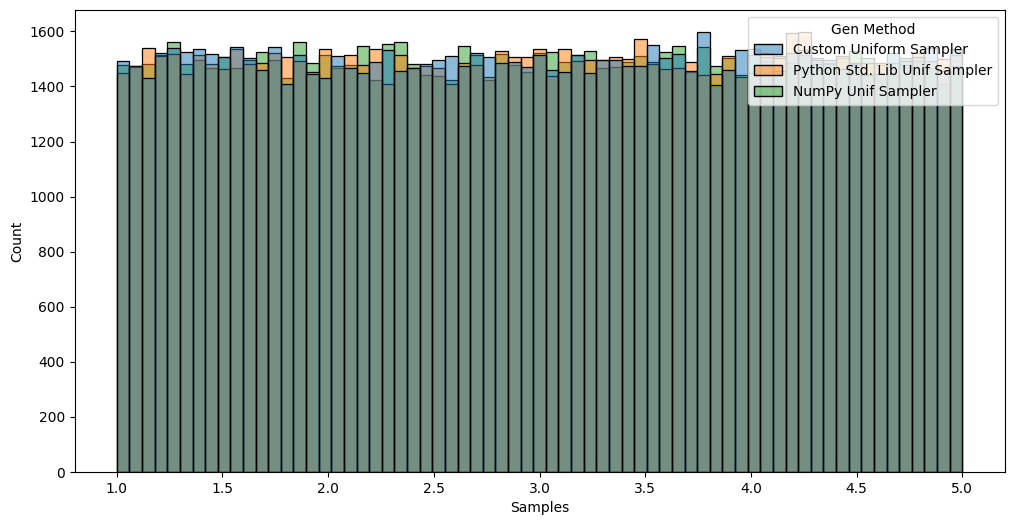

In [54]:
plt.figure(figsize=(12, 6))

sns.histplot(uniform_df, x="Samples", hue="Gen Method")

plt.show()

#### 1.B. Implement simple sampling from continuous distributions: gaussian (mu, sigma, sample_size)

In [128]:
class GaussianRejectionSampler:

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

        self.support_lb = self.mu -  3 * self.sigma
        self.support_ub = self.mu +  3 * self.sigma

        self.candidate_density_sampler = UniformInverseTranformSamper(
            a=self.support_lb, b=self.support_ub
        )

        self.M = self.set_M()

    
    def set_M(self):
        x = np.linspace(self.support_lb, self.support_ub, num=int(1e6))
        
        target_density = norm.pdf(x, loc=self.mu, scale=self.sigma)
        candidate_density = uniform.pdf(
            x, loc=self.support_lb, scale=2 * self.support_ub
        )

        return np.max(target_density / candidate_density)
        
    
    def sample(self, n_samples):
        samples = []

        while len(samples) < n_samples:
            u = random.uniform(0.0, 1.0)

            X = self.candidate_density_sampler.sample(n_samples=1)[0]
            
            f_X = norm.pdf(X, loc=self.mu, scale=self.sigma)
            g_X =  uniform.pdf(
                X, loc=self.support_lb, scale=2 * self.support_ub
            )
    
            if u <= f_X / (self.M * g_X):
                samples.append(X)

        return samples

In [129]:
n_samples = int(1e4)

sampler = GaussianRejectionSampler(mu=0, sigma=3)
samples = sampler.sample(n_samples)

In [130]:
test_samples = np.random.normal(loc=0, scale=3, size=n_samples)
test_samples.shape

(10000,)

In [134]:
gaussian_df = pd.DataFrame(
    data=[],
    columns=["Samples", "Gen Method"]
)

gauss_samples = [samples, test_samples]
gen_methods = ["Custom Gaussian Sampler", "NumPy Gaussian Sampler"]

for _samples, _gen_method in zip(gauss_samples, gen_methods):
    df = pd.DataFrame()
    
    df["Samples"] = _samples
    df["Gen Method"] = _gen_method
    
    gaussian_df = pd.concat([gaussian_df, df], axis=0)

gaussian_df.shape

/tmp/ipykernel_6108/934023309.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaussian_df = pd.concat([gaussian_df, df], axis=0)


(20000, 2)

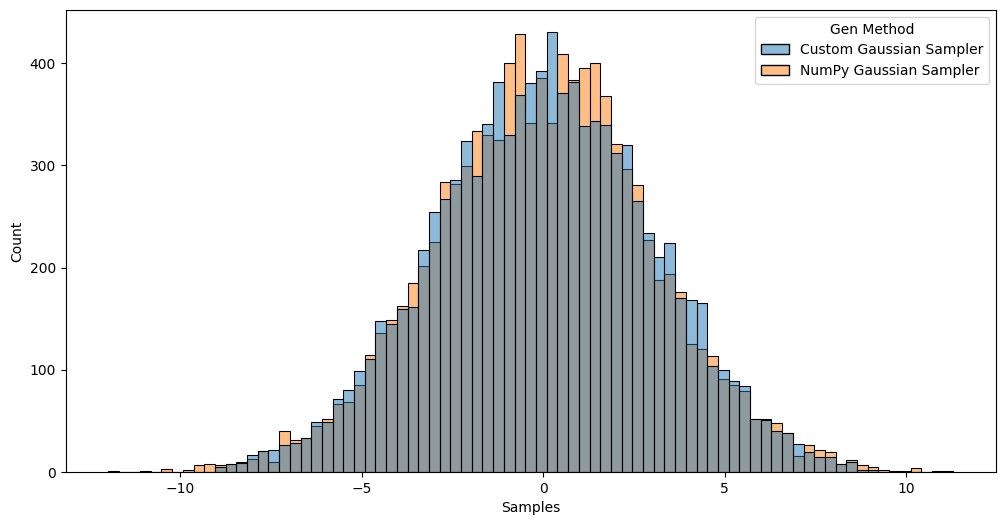

In [135]:
plt.figure(figsize=(12, 6))

sns.histplot(gaussian_df, x="Samples", hue="Gen Method")

plt.show()

#### B. Implement sampling from a 2-dim Gaussian Distribution (2d mu, 2d sigma, sample_size)

In [5]:
mean = np.array([0, 0])
cov = np.array([[4, 2], [2, 4]])

In [7]:
n_samples = int(1e4)
test_samples = np.random.multivariate_normal(mean, cov, size=n_samples)

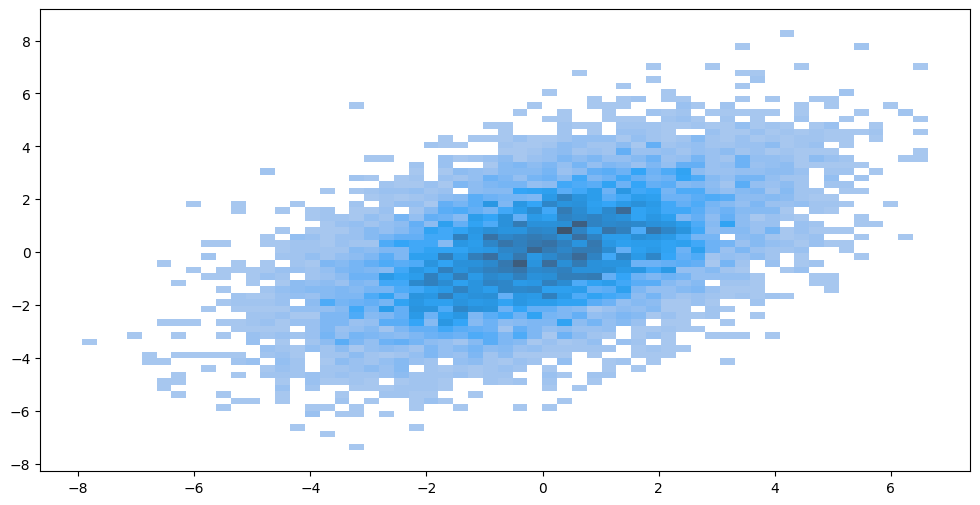

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(x=test_samples[:, 0], y=test_samples[:, 1])
plt.show()

In [17]:
def gaussian_2d_sampling(mu: np.array, cov: np.array, n_samples: int) -> np.array:
    L = np.linalg.cholesky(cov)

    d = len(mu)
    z = np.random.randn(n_samples, d)

    samples = np.dot(z, L.T) + mean

    return samples

In [20]:
gauss_samples = gaussian_2d_sampling(mean, cov, n_samples)
gauss_samples.shape

(10000, 2)

In [23]:
gauss_2d_df = pd.DataFrame()

samples = [gauss_samples, test_samples]
gen_methods = ["2D Gaussian Sampling using Box Muller Tranform", "NumPy Multivariate Norm PDF"]

for _sample, _gen_method in zip(samples, gen_methods):
    df = pd.DataFrame()
    df["X1"] = _sample[:, 0]
    df["X2"] = _sample[:, 1]
    df["Gen Method"] = _gen_method

    gauss_2d_df = pd.concat([gauss_2d_df, df], axis=0)

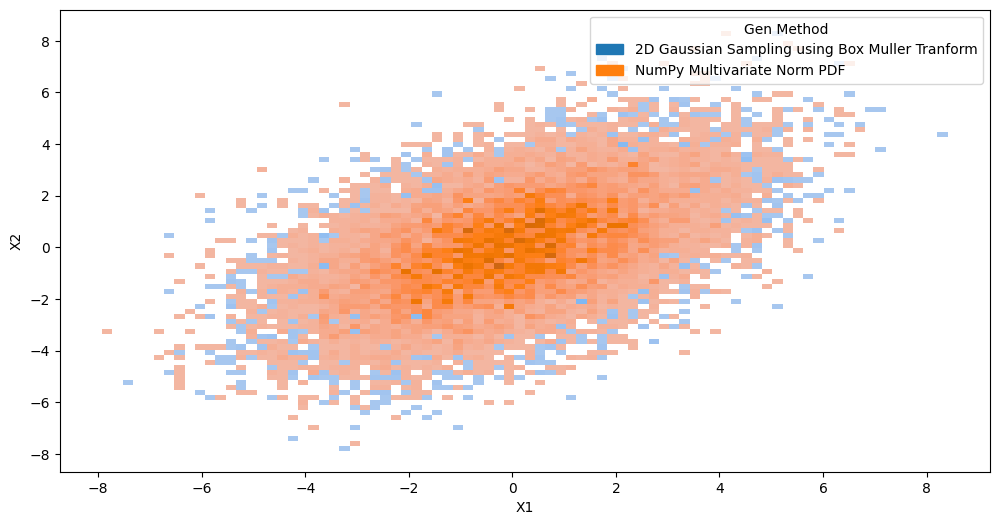

In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(data=gauss_2d_df, x="X1", y="X2", hue="Gen Method")
plt.show()

#### C. Implement without-replacement sampling from a discrete non-uniform distribution (given as input) following the Steven's method. Test it on desired sample sizes N significantly smaller than population size M (for example N=20 M=300)

In [214]:
support_lb = 0.1
support_ub = 0.9

n_population = int(1e5)

x = np.linspace(support_lb, support_ub, n_population)
x.shape

(100000,)

In [218]:
def get_probs(x: np.array) -> np.array:
    logits = np.exp(-x)
    
    probs = logits/ np.sum(logits)

    return probs

In [219]:
probs = get_probs(x)
probs.shape

(100000,)

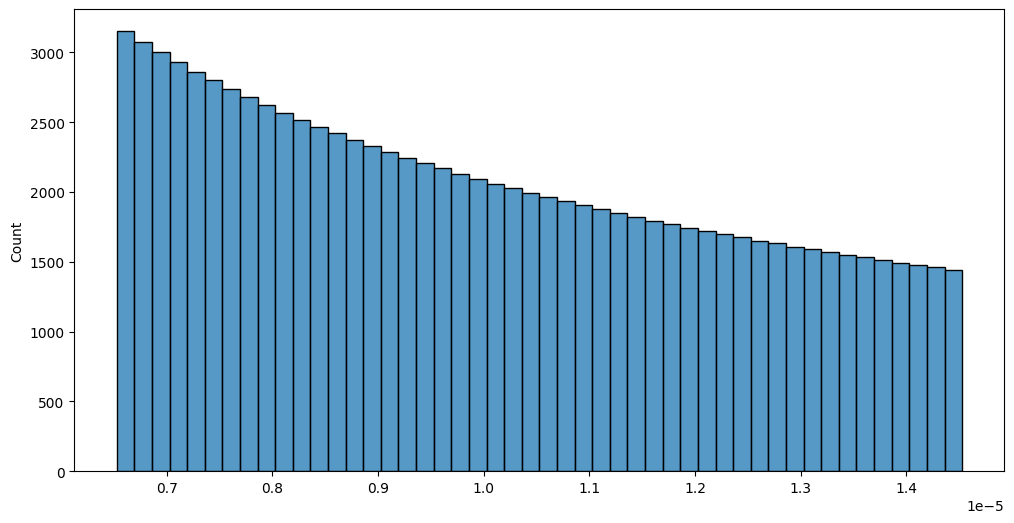

In [237]:
plt.figure(figsize=(12, 6))

sns.histplot(x=probs)

plt.show()

In [221]:
def stevens_sampling(x: np.array, k: int):
    n = len(x)
    
    probs = get_probs(x)
    x2prob = {k: v for k, v in zip(x, probs)}
    x2prob = dict(sorted(x2prob.items(), key=lambda item: -item[1]))

    keys = list(x2prob.keys())

    groups = []
    group_prob = {}
    for group_idx, idx in enumerate(range(0, n, k)):
        groups.append(keys[idx : idx + k])

        pmf = 0
        for key in keys[idx : idx + k]:
            pmf += x2prob[key]

        group_prob[group_idx] = pmf

    samples = []
    samples_picked = [set() for _ in range(len(groups))]

    while len(samples) < k:
        group_id = np.random.choice(a=np.arange(len(groups)), p=list(group_prob.values()))

        sample = np.random.choice(a=groups[group_id])

        if sample in samples_picked[group_id]:
            continue

        samples.append(sample)
        samples_picked[group_id].add(sample)

    return samples

In [223]:
n_samples = int(1e4)

samples = stevens_sampling(x, k=n_samples)

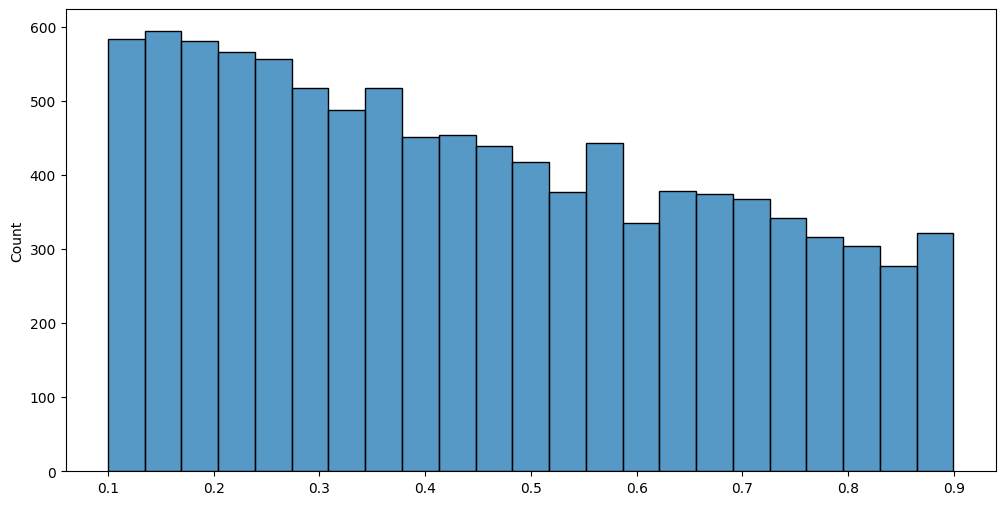

In [236]:
plt.figure(figsize=(12, 6))
sns.histplot(x=samples)
plt.show()